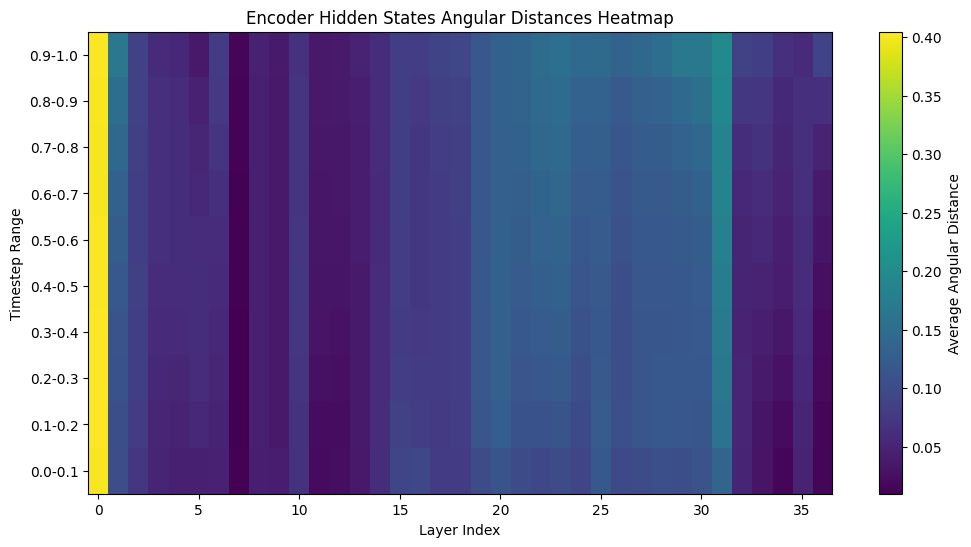

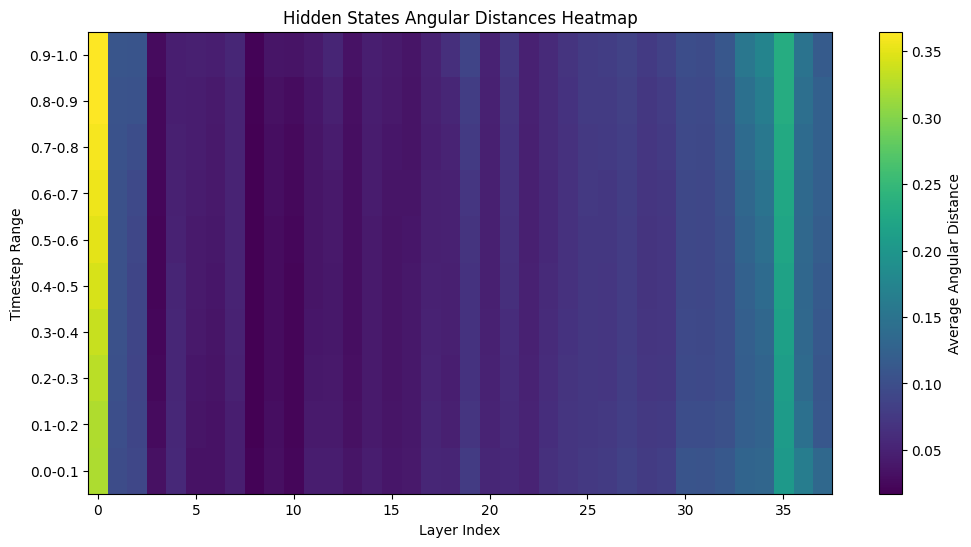

In [43]:
# ! pip install numpy
# ! pip install matplotlib

import json
import numpy as np
import matplotlib.pyplot as plt

# Number of bins
n_bins = 10

# Initialize bins
bins = [[] for _ in range(n_bins)]

# Define the bin edges
edges = [i / n_bins for i in range(n_bins + 1)]  # [0.0, 0.1, 0.2, ..., 1.0]

# Load data from JSONL file
data = []
with open('sd3_hidden_state_similarity.jsonl', 'r') as f:
    for line in f:
        d = json.loads(line)
        data.append(d)

# Bin the data based on timestep
for d in data:
    timestep = d['timestep']
    # Handle edge case where timestep == 1.0
    if timestep == 1.0:
        bins[-1].append(d)
        continue
    # Find the appropriate bin
    for i in range(n_bins):
        if edges[i] <= timestep < edges[i + 1]:
            bins[i].append(d)
            break
    else:
        print(f"Warning: Timestep {timestep} out of bounds")

# Determine the maximum number of layers
max_layers_encoder = max(len(d['encoder_hidden_states']) for d in data)
max_layers_hidden = max(len(d['hidden_states']) for d in data)

# Initialize heatmaps and counts
encoder_heatmap = np.zeros((n_bins, max_layers_encoder))
hidden_heatmap = np.zeros((n_bins, max_layers_hidden))
encoder_counts = np.zeros((n_bins, max_layers_encoder))
hidden_counts = np.zeros((n_bins, max_layers_hidden))

# Aggregate angular distances
for bin_index, bin_data in enumerate(bins):
    for d in bin_data:
        encoder_distances = d['encoder_hidden_states']
        hidden_distances = d['hidden_states']
        # Accumulate encoder distances
        for layer_index, distance in enumerate(encoder_distances):
            encoder_heatmap[bin_index, layer_index] += distance
            encoder_counts[bin_index, layer_index] += 1
        # Accumulate hidden distances
        for layer_index, distance in enumerate(hidden_distances):
            hidden_heatmap[bin_index, layer_index] += distance
            hidden_counts[bin_index, layer_index] += 1

# Compute the average angular distances
encoder_heatmap = np.divide(
    encoder_heatmap, encoder_counts, out=np.zeros_like(encoder_heatmap), where=encoder_counts != 0
)
hidden_heatmap = np.divide(
    hidden_heatmap, hidden_counts, out=np.zeros_like(hidden_heatmap), where=hidden_counts != 0
)

# Define labels for the y-axis (timestep bins)
y_labels = [f"{edges[i]:.1f}-{edges[i+1]:.1f}" for i in range(n_bins)]

# Plot Encoder Hidden States Heatmap
plt.figure(figsize=(12, 6))
plt.imshow(encoder_heatmap, aspect='auto', origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Average Angular Distance')
plt.title('Encoder Hidden States Angular Distances Heatmap')
plt.xlabel('Layer Index')
plt.ylabel('Timestep Range')
plt.yticks(ticks=np.arange(n_bins), labels=y_labels)
plt.show()

# Plot Hidden States Heatmap
plt.figure(figsize=(12, 6))
plt.imshow(hidden_heatmap, aspect='auto', origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Average Angular Distance')
plt.title('Hidden States Angular Distances Heatmap')
plt.xlabel('Layer Index')
plt.ylabel('Timestep Range')
plt.yticks(ticks=np.arange(n_bins), labels=y_labels)
plt.show()

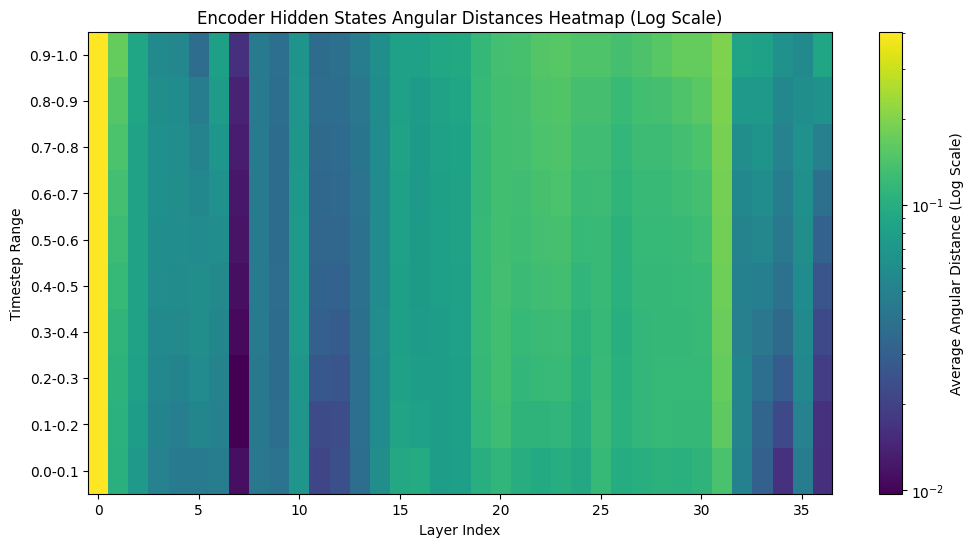

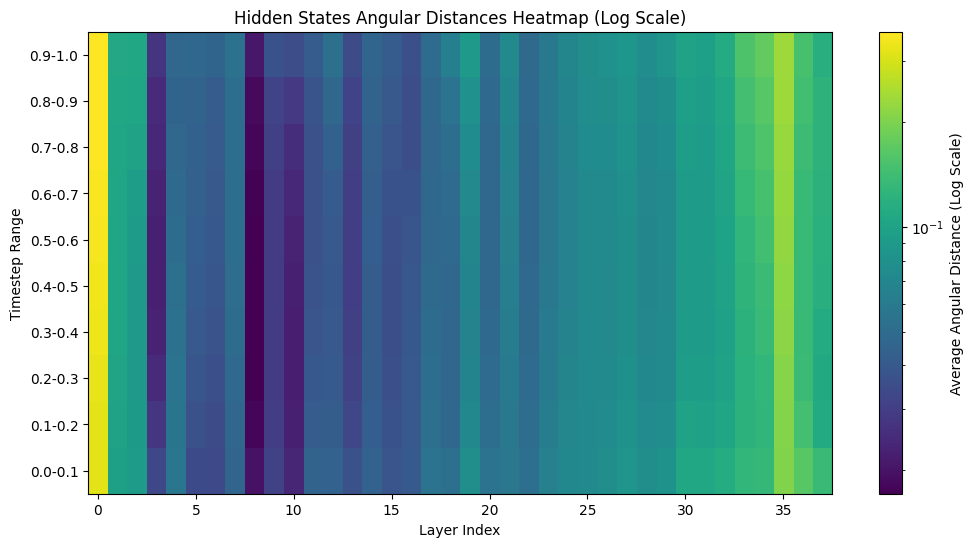

In [44]:
import matplotlib.colors as colors

# Plot Encoder Hidden States Heatmap with Logarithmic Color Scale
plt.figure(figsize=(12, 6))
plt.imshow(
    encoder_heatmap,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='viridis',
    norm=colors.LogNorm(
        vmin=max(encoder_heatmap.min(), 1e-8),  # Ensure vmin > 0
        vmax=encoder_heatmap.max()
    )
)
plt.colorbar(label='Average Angular Distance (Log Scale)')
plt.title('Encoder Hidden States Angular Distances Heatmap (Log Scale)')
plt.xlabel('Layer Index')
plt.ylabel('Timestep Range')
plt.yticks(ticks=np.arange(n_bins), labels=y_labels)
plt.show()

# Plot Hidden States Heatmap with Logarithmic Color Scale
plt.figure(figsize=(12, 6))
plt.imshow(
    hidden_heatmap,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='viridis',
    norm=colors.LogNorm(
        vmin=max(hidden_heatmap.min(), 1e-8),  # Ensure vmin > 0
        vmax=hidden_heatmap.max()
    )
)
plt.colorbar(label='Average Angular Distance (Log Scale)')
plt.title('Hidden States Angular Distances Heatmap (Log Scale)')
plt.xlabel('Layer Index')
plt.ylabel('Timestep Range')
plt.yticks(ticks=np.arange(n_bins), labels=y_labels)
plt.show()

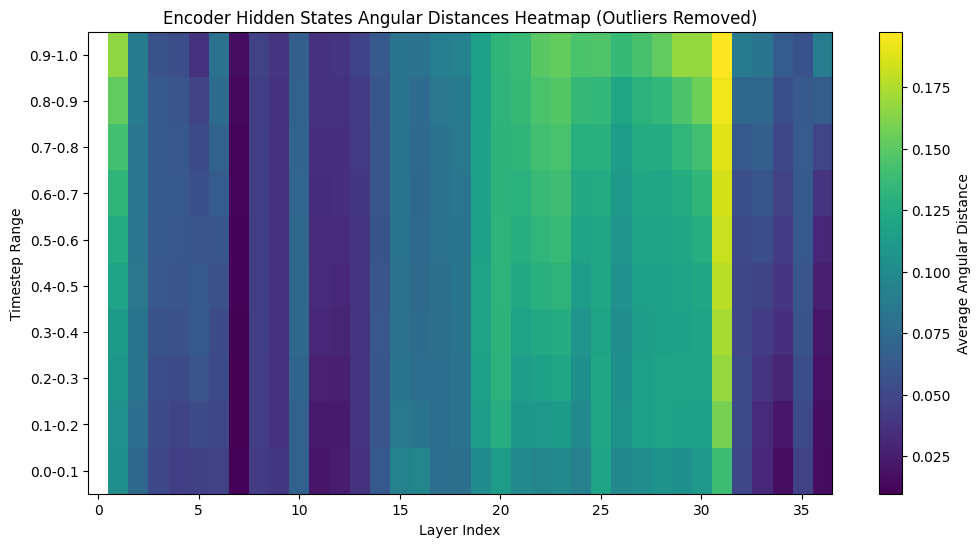

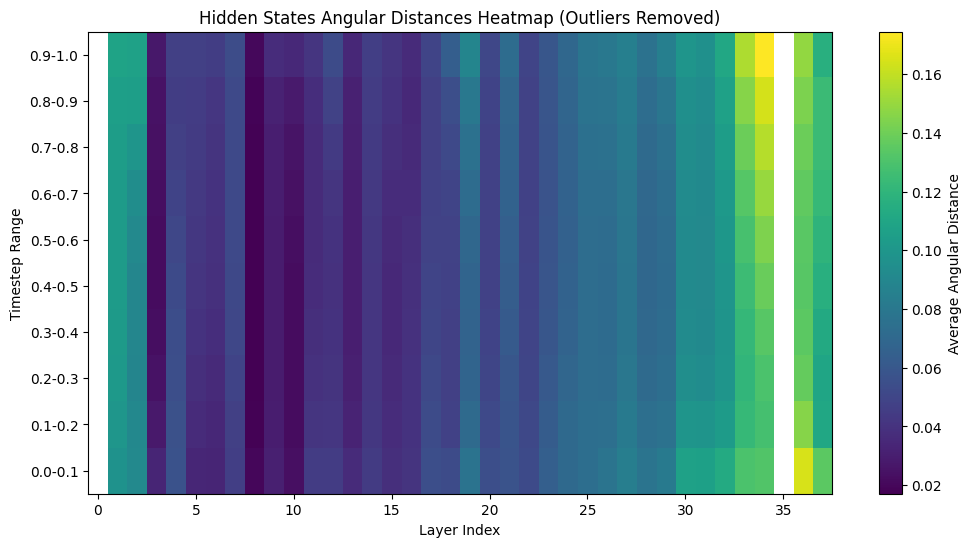

In [45]:
# ! pip install scipy

from scipy.stats import zscore

# Flatten the data and compute Z-scores
encoder_flat = encoder_heatmap.flatten()
encoder_zscores = zscore(encoder_flat)
hidden_flat = hidden_heatmap.flatten()
hidden_zscores = zscore(hidden_flat)

# Define Z-score threshold for outliers
z_threshold = 2  # Adjust as needed

# Replace outliers with NaN
encoder_filtered = np.where(np.abs(encoder_zscores) > z_threshold, np.nan, encoder_flat)
hidden_filtered = np.where(np.abs(hidden_zscores) > z_threshold, np.nan, hidden_flat)

# Reshape to original heatmap shape
encoder_heatmap_filtered = encoder_filtered.reshape(encoder_heatmap.shape)
hidden_heatmap_filtered = hidden_filtered.reshape(hidden_heatmap.shape)

# Plot Encoder Hidden States Heatmap without Outliers
plt.figure(figsize=(12, 6))
plt.imshow(
    encoder_heatmap_filtered,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='viridis',
    vmin=np.nanmin(encoder_heatmap_filtered),
    vmax=np.nanmax(encoder_heatmap_filtered)
)
plt.colorbar(label='Average Angular Distance')
plt.title('Encoder Hidden States Angular Distances Heatmap (Outliers Removed)')
plt.xlabel('Layer Index')
plt.ylabel('Timestep Range')
plt.yticks(ticks=np.arange(n_bins), labels=y_labels)
plt.show()

# Plot Hidden States Heatmap without Outliers
plt.figure(figsize=(12, 6))
plt.imshow(
    hidden_heatmap_filtered,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='viridis',
    vmin=np.nanmin(hidden_heatmap_filtered),
    vmax=np.nanmax(hidden_heatmap_filtered)
)
plt.colorbar(label='Average Angular Distance')
plt.title('Hidden States Angular Distances Heatmap (Outliers Removed)')
plt.xlabel('Layer Index')
plt.ylabel('Timestep Range')
plt.yticks(ticks=np.arange(n_bins), labels=y_labels)
plt.show()

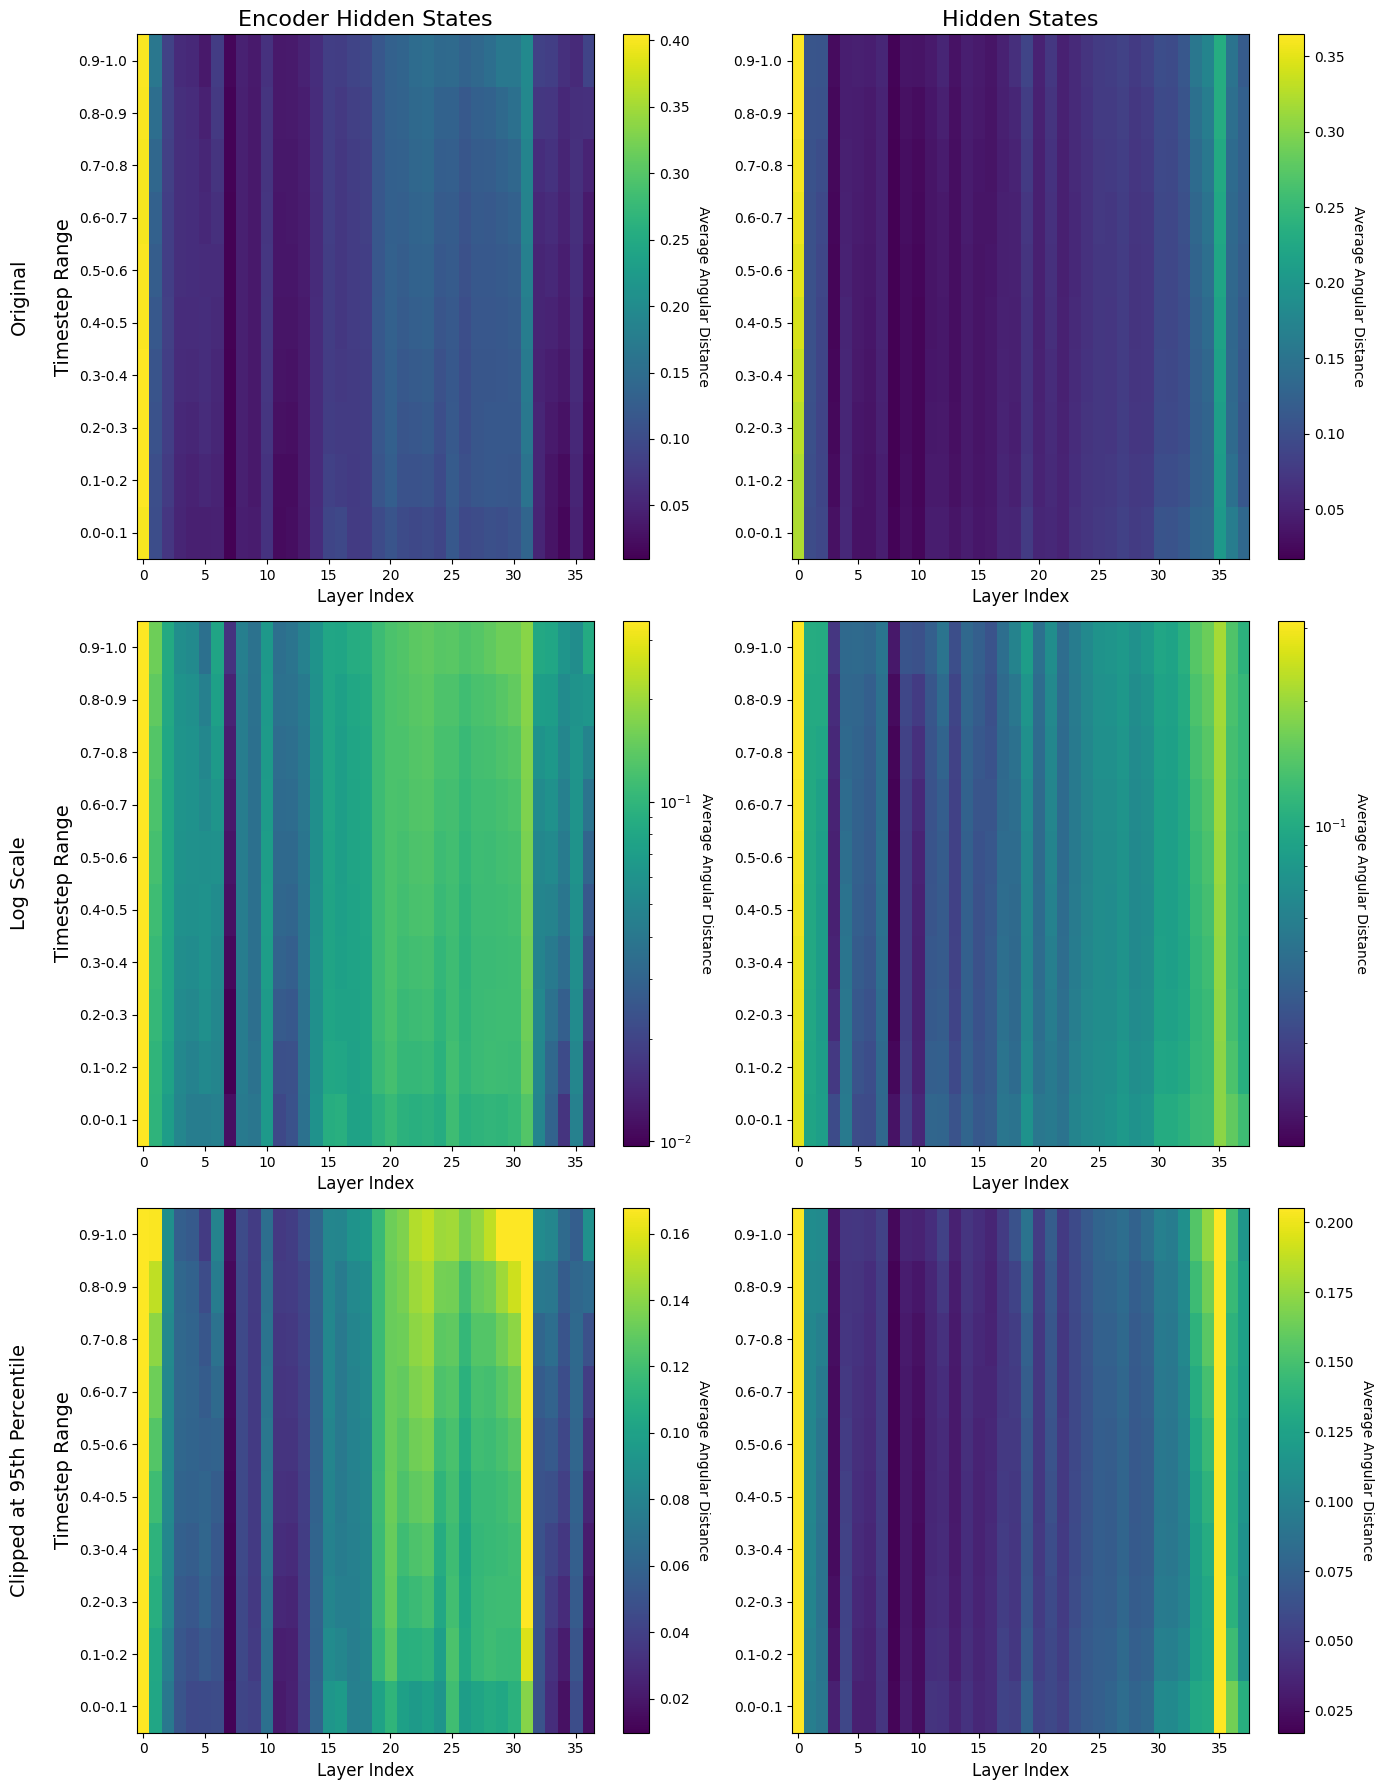

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Assume that the following arrays are already computed:
# encoder_heatmap, hidden_heatmap
# encoder_heatmap_log, hidden_heatmap_log
# encoder_heatmap_clipped, hidden_heatmap_clipped

# For illustration purposes, let's create some dummy data
# Replace these with your actual heatmaps
encoder_heatmap_log = np.log1p(encoder_heatmap)
hidden_heatmap_log = np.log1p(hidden_heatmap)
encoder_heatmap_clipped = np.clip(encoder_heatmap, None, np.percentile(encoder_heatmap, 95))
hidden_heatmap_clipped = np.clip(hidden_heatmap, None, np.percentile(hidden_heatmap, 95))

# Labels for the y-axis (timestep ranges)
n_bins = 10
edges = [i / n_bins for i in range(n_bins + 1)]  # [0.0, 0.1, ..., 1.0]
y_labels = [f"{edges[i]:.1f}-{edges[i+1]:.1f}" for i in range(n_bins)]

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

# Visualization methods
methods = ['Original', 'Log Scale', 'Clipped at 95th Percentile']

# Heatmaps to plot
encoder_heatmaps = [encoder_heatmap, encoder_heatmap_log, encoder_heatmap_clipped]
hidden_heatmaps = [hidden_heatmap, hidden_heatmap_log, hidden_heatmap_clipped]

# Titles for each subplot
titles = [
    'Encoder Hidden States',
    'Hidden States'
]

# Plotting loop
for row in range(3):
    for col in range(2):
        ax = axes[row, col]
        heatmap = encoder_heatmaps[row] if col == 0 else hidden_heatmaps[row]
        
        # Choose normalization based on method
        if methods[row] == 'Log Scale':
            norm = colors.LogNorm(
                vmin=max(heatmap.min(), 1e-8),
                vmax=heatmap.max()
            )
        else:
            norm = None
        
        im = ax.imshow(
            heatmap,
            aspect='auto',
            origin='lower',
            interpolation='nearest',
            cmap='viridis',
            norm=norm
        )
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Average Angular Distance', rotation=270, labelpad=15)
        
        # Set titles and labels
        if row == 0:
            ax.set_title(titles[col], fontsize=16)
        if col == 0:
            ax.set_ylabel(f'{methods[row]}\n\nTimestep Range', fontsize=14)
        else:
            ax.set_ylabel('')  # No need to repeat ylabel
        ax.set_xlabel('Layer Index', fontsize=12)
        ax.set_yticks(np.arange(n_bins))
        ax.set_yticklabels(y_labels)
        
        # Adjust ticks and labels
        ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure (optional)
plt.savefig('angular_distances_heatmaps.png', dpi=300)

# Show the figure
plt.show()

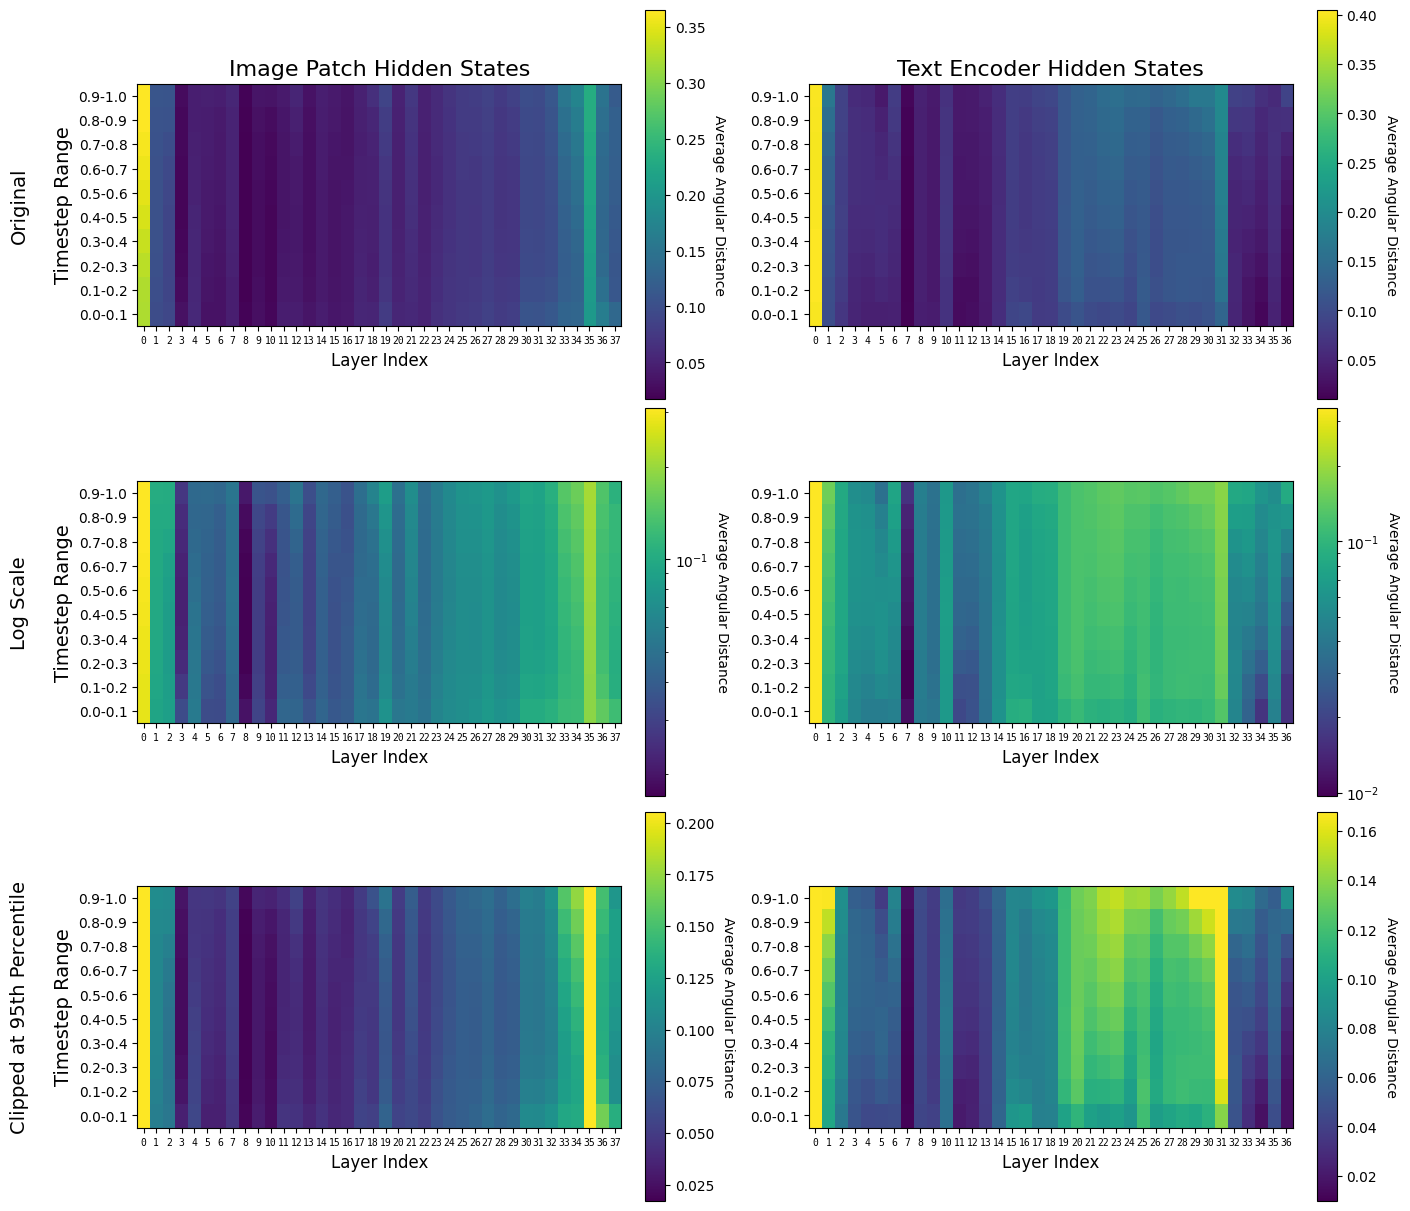

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Assume that the following arrays are already computed:
# encoder_heatmap, hidden_heatmap
# encoder_heatmap_log, hidden_heatmap_log
# encoder_heatmap_clipped, hidden_heatmap_clipped

# Labels for the y-axis (timestep ranges)
n_bins = 10
edges = [i / n_bins for i in range(n_bins + 1)]  # [0.0, 0.1, ..., 1.0]
y_labels = [f"{edges[i]:.1f}-{edges[i+1]:.1f}" for i in range(n_bins)]

# Set up the figure and axes with adjusted figure size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), constrained_layout=True)

# Visualization methods
methods = ['Original', 'Log Scale', 'Clipped at 95th Percentile']

# Heatmaps to plot
encoder_heatmaps = [encoder_heatmap, encoder_heatmap_log, encoder_heatmap_clipped]
hidden_heatmaps = [hidden_heatmap, hidden_heatmap_log, hidden_heatmap_clipped]

# Titles for each subplot
titles = [
    'Image Patch Hidden States',
    'Text Encoder Hidden States'
]

# Scaling factor to compress the y-axis
scaling_factor = 0.5  # Adjust this value between 0 and 1 as needed

# Plotting loop
for row in range(3):
    for col in range(2):
        ax = axes[row, col]
        heatmap = encoder_heatmaps[row] if col == 1 else hidden_heatmaps[row]
        
        # Choose normalization based on method
        if methods[row] == 'Log Scale':
            norm = colors.LogNorm(
                vmin=max(heatmap.min(), 1e-8),
                vmax=heatmap.max()
            )
        else:
            norm = None
        
        im = ax.imshow(
            heatmap,
            aspect='auto',  # Allow the aspect ratio to adjust
            origin='lower',
            interpolation='nearest',
            cmap='viridis',
            norm=norm
        )
        
        # Set titles and labels
        if row == 0:
            ax.set_title(titles[col], fontsize=16)
        if col == 0:
            ax.set_ylabel(f'{methods[row]}\n\nTimestep Range', fontsize=14)
        else:
            ax.set_ylabel('')  # No need to repeat ylabel
        ax.set_xlabel('Layer Index', fontsize=12)
        ax.set_yticks(np.arange(n_bins))
        ax.set_yticklabels(y_labels)
        ax.set_xticks(range(max_layers_encoder) if col == 1 else range(max_layers_hidden))
        
        # Adjust ticks and labels
        ax.tick_params(axis='y', which='major', labelsize=10)
        ax.tick_params(axis='x', which='major', labelsize=7)

        # Set the tick label font family
        for label in ax.get_xticklabels():
            label.set_fontfamily('DejaVu Sans Mono')  # Replace 'serif' with your desired font family

        # Adjust the aspect ratio by setting data aspect
        # Calculate the aspect ratio
        y_points, x_points = heatmap.shape
        aspect_ratio = (x_points / y_points) * scaling_factor  # Compress the y-axis
        ax.set_aspect(aspect_ratio)

        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Average Angular Distance', rotation=270, labelpad=15)

# Adjust layout to prevent overlap
# plt.tight_layout()
# plt.subplots(layout="constrained")

# Save the figure (optional)
plt.savefig('angular_distances_heatmaps_adjusted.png', dpi=300)

# Show the figure
plt.show()

(10, 37)


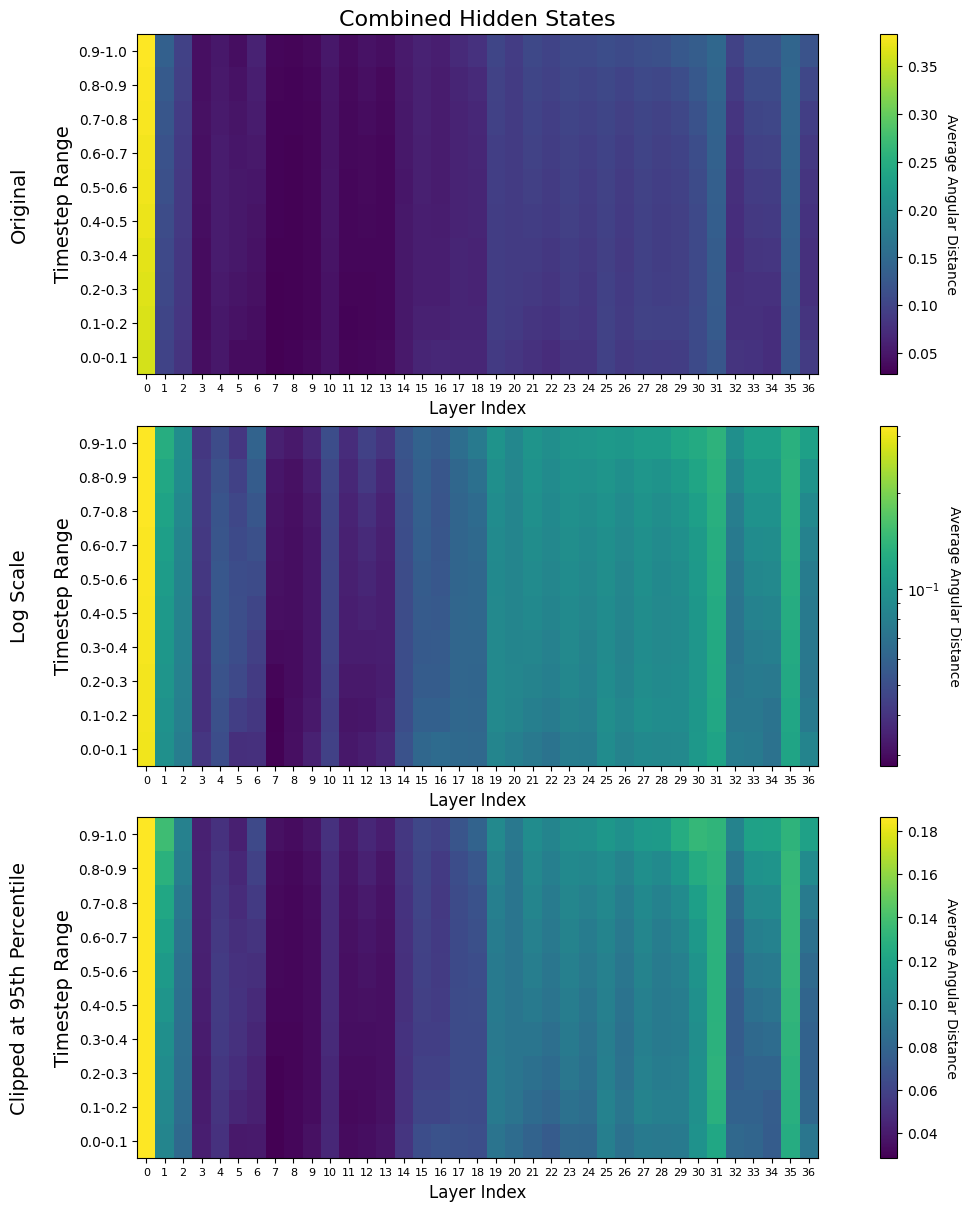

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Assume that the following arrays are already computed:
# encoder_heatmap, hidden_heatmap
# encoder_heatmap_log, hidden_heatmap_log
# encoder_heatmap_clipped, hidden_heatmap_clipped

# Labels for the y-axis (timestep ranges)
n_bins = 10
edges = [i / n_bins for i in range(n_bins + 1)]  # [0.0, 0.1, ..., 1.0]
y_labels = [f"{edges[i]:.1f}-{edges[i+1]:.1f}" for i in range(n_bins)]

# Set up the figure and axes with adjusted figure size
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Visualization methods
methods = ['Original', 'Log Scale', 'Clipped at 95th Percentile']

# Heatmaps to plot
encoder_heatmaps = [encoder_heatmap, encoder_heatmap_log, encoder_heatmap_clipped]
hidden_heatmaps = [hidden_heatmap, hidden_heatmap_log, hidden_heatmap_clipped]
combined_heatmaps = [
    np.add(encoder_heatmap, hidden_heatmap[:, :-1]) / 2.0,
    np.add(encoder_heatmap_log, hidden_heatmap_log[:, :-1]) / 2.0,
    np.add(encoder_heatmap_clipped,  hidden_heatmap_clipped[:, :-1]) / 2.0,
]
print(combined_heatmaps[0].shape)

# Titles for each subplot
title = 'Combined Hidden States'

# Scaling factor to compress the y-axis
scaling_factor = 0.5  # Adjust this value between 0 and 1 as needed

# Plotting loop
for row in range(3):
    ax = axes[row]
    heatmap = combined_heatmaps[row]
    
    # Choose normalization based on method
    if methods[row] == 'Log Scale':
        norm = colors.LogNorm(
            vmin=max(heatmap.min(), 1e-8),
            vmax=heatmap.max()
        )
    else:
        norm = None
    
    im = ax.imshow(
        heatmap,
        aspect='auto',  # Allow the aspect ratio to adjust
        origin='lower',
        interpolation='nearest',
        cmap='viridis',
        norm=norm
    )
    
    # Set titles and labels
    if row == 0:
        ax.set_title(title, fontsize=16)
    ax.set_ylabel(f'{methods[row]}\n\nTimestep Range', fontsize=14)
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_yticks(np.arange(n_bins))
    ax.set_yticklabels(y_labels)
    ax.set_xticks(range(max_layers_encoder) if col == 1 else range(max_layers_hidden))
    
    # Adjust ticks and labels
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.tick_params(axis='x', which='major', labelsize=8)
    
    # Adjust the aspect ratio by setting data aspect
    # Calculate the aspect ratio
    y_points, x_points = heatmap.shape
    aspect_ratio = (x_points / y_points) * scaling_factor  # Compress the y-axis
    ax.set_aspect(aspect_ratio)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Average Angular Distance', rotation=270, labelpad=15)

# Adjust layout to prevent overlap
# plt.tight_layout()

# Save the figure (optional)
plt.savefig('angular_distances_heatmaps_combined.png', dpi=300)

# Show the figure
plt.show()

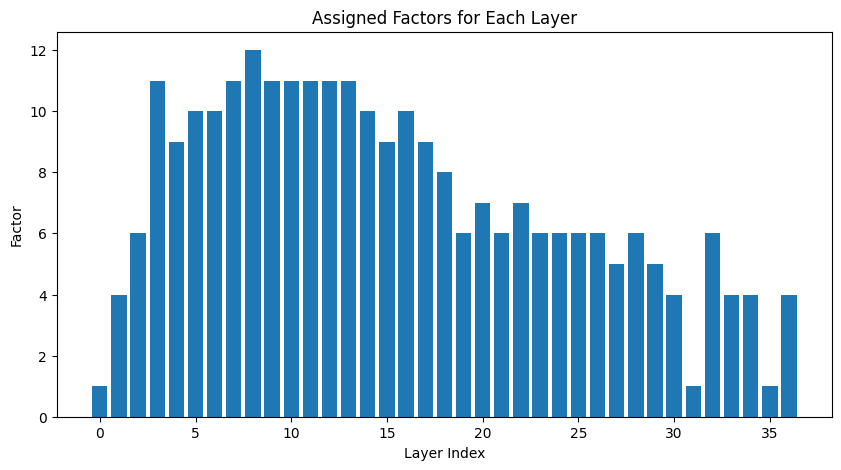

In [49]:
import numpy as np
import math
import json
import matplotlib.pyplot as plt

TASK_WEIGHT_IMAGE = (2/3)
TASK_WEIGHT_TEXT = (1/3)

# Assuming 'encoder_heatmap' and 'hidden_heatmap' are already computed

# Combine and clip the heatmaps at the 90th percentile
encoder_heatmap_clipped_90 = np.clip(encoder_heatmap, None, np.percentile(encoder_heatmap, 90)) * TASK_WEIGHT_TEXT
hidden_heatmap_clipped_90 = np.clip(hidden_heatmap, None, np.percentile(hidden_heatmap, 90)) * TASK_WEIGHT_IMAGE
clipped_combined_heatmap_90 = np.add(encoder_heatmap_clipped_90, hidden_heatmap_clipped_90[:, :-1]) / 2.0

# Compute per-layer averages by averaging over the timestep dimension (axis 0)
per_layer_averages = np.mean(clipped_combined_heatmap_90, axis=0)  # Shape: (n_layers,)

# Invert and normalize the per-layer averages to get higher contributions corresponding to lower factors
normalized_contributions = (per_layer_averages - per_layer_averages.min()) / (per_layer_averages.max() - per_layer_averages.min())
inverted_normalized_contributions = 1 - normalized_contributions

# Define maximum factor F (e.g., 6)
F = 12

# Map the inverted normalized contributions to factors in the range [1, F]
factors_float = inverted_normalized_contributions * (F - 1) + 1
factors = np.round(factors_float).astype(int)

# Ensure factors are within [1, F]
factors = np.clip(factors, 1, F)

# Critical layers to assign the lowest factor (more parameters)
critical_layers = [0, 31, 35]

# Adjust factors for critical layers
for n in critical_layers:
    if n < len(factors):
        factors[n] = 1  # Assign the lowest factor
    else:
        print(f"Warning: Layer {n} is out of bounds.")

# Now, generate the 'name_algo_map' using these factors
name_algo_map = {}

for n in range(len(factors) + 1):
    if n < len(factors):
        f_n = factors[n]  # Factor for layer n
    else:
        # Use the last factor for the extra layer (if applicable)
        f_n = factors[-1]
    # Entries for 'norm1*', 'norm1_context*', 'ff*' with factor f_n
    for key_suffix in ['norm1*', 'norm1_context*', 'ff*']:
        key = f"transformer_blocks.{n}.{key_suffix}"
        name_algo_map[key] = {
            "algo": "lokr",
            "factor": math.ceil(f_n),
            "linear_dim": 1000000,
            "linear_alpha": 1,
            "full_matrix": True
        }
    # Entry for 'transformer_blocks.{n}.*' with factor 2*f_n
    key = f"transformer_blocks.{n}.*"
    name_algo_map[key] = {
        "algo": "lokr",
        "factor": 2 * math.ceil(f_n),
        "linear_dim": 1000000,
        "linear_alpha": 1,
        "full_matrix": True
    }

# Incorporate 'name_algo_map' into your configuration
config = {
    "algo": "lokr",
    "multiplier": 1.0,
    "linear_dim": 1000000,
    "linear_alpha": 1,
    "factor": 1,
    "full_matrix": True,
    "apply_preset": {
        "target_module": [
            "JointTransformerBlock",
        ],
        "name_algo_map": name_algo_map,
        "use_fnmatch": True
    }
}

# Save the configuration to a JSON file
with open('peft_config.json', 'w') as f:
    json.dump(config, f, indent=4)

# Visualize the assigned factors
plt.figure(figsize=(10, 5))
plt.bar(range(len(factors)), factors)
plt.xlabel('Layer Index')
plt.ylabel('Factor')
plt.title('Assigned Factors for Each Layer')
plt.savefig('peft_config.png')
plt.show()